## Import TensorFlow and other libraries

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.models import Model

## Load the dataset
To start, you will train the basic autoencoder using the Fashion MNIST dataset. Each image in this dataset is 28x28 pixels.

In [57]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


## First example: Basic autoencoder
![Basic autoencoder results](images/intro_autoencoder_result.png)

Define an autoencoder with two Dense layers: an `encoder`, which compresses the images into a 64 dimensional latent vector, and a `decoder`, that reconstructs the original image from the latent space.

To define your model, use the [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models).


In [58]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = x_test.shape[1:]
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)

In [59]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Train the model using `x_train` as both the input and the target. The `encoder` will learn to compress the dataset from 784 dimensions to the latent space, and the `decoder` will learn to reconstruct the original images.
.

In [60]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [61]:
%%time

with tf.device('/device:GPU:0'):
    history1 = autoencoder.fit(x_train, x_train,
                epochs=50,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0241 - val_loss: 0.0094
Epoch 2/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0070 - val_loss: 0.0054
Epoch 3/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 4/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 5/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 6/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 7/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 8/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 9/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 10/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.004

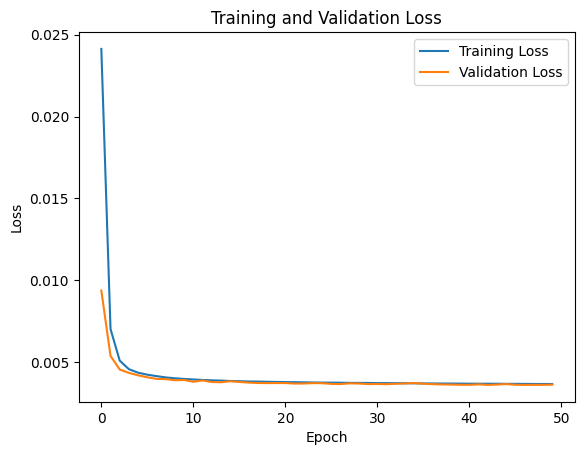

In [62]:
# Extract loss values from history
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']

# Plot training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Now that the model is trained, let's test it by encoding and decoding images from the test set.

In [63]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

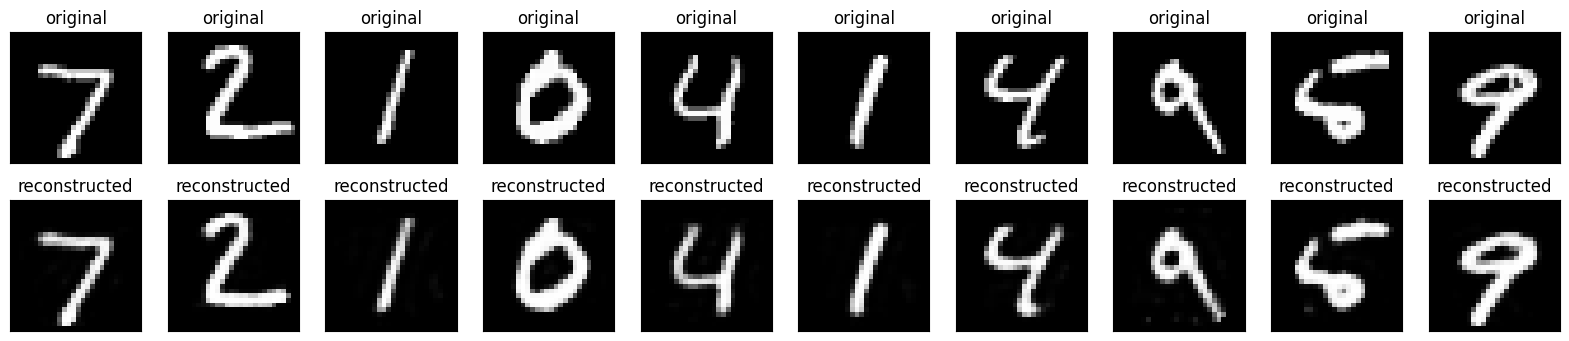

In [64]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Second example: Image denoising


![Image denoising results](images/image_denoise_fmnist_results.png)

An autoencoder can also be trained to remove noise from images. In the following section, you will create a noisy version of the Fashion MNIST dataset by applying random noise to each image. You will then train an autoencoder using the noisy image as input, and the original image as the target.

Let's reimport the dataset to omit the modifications made earlier.

In [65]:
(x_train, _), (x_test, _) = mnist.load_data()

In [66]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


Adding random noise to the images

In [67]:
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

Plot the noisy images.


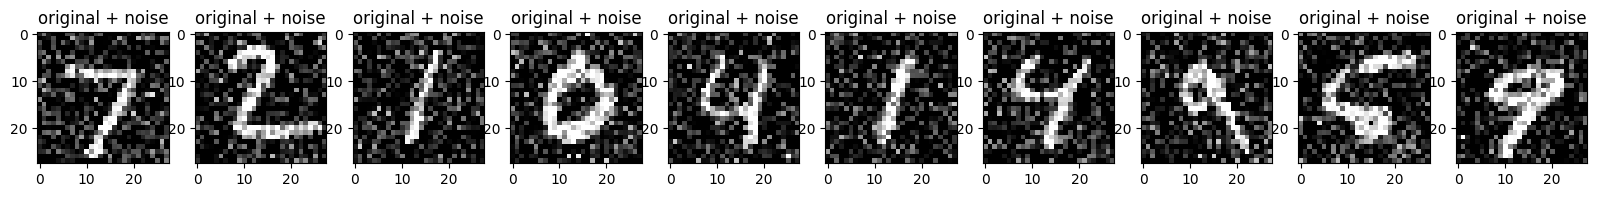

In [68]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### Define a convolutional autoencoder

In this example, you will train a convolutional autoencoder using  [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers in the `encoder`, and [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers in the `decoder`.

In [69]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [70]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [71]:
%%time

with tf.device('/device:GPU:0'):
    history2 = autoencoder.fit(x_train_noisy, x_train,
                epochs=50,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/50
1875/1875 [==============================] - 8s 3ms/step - loss: 0.1139 - val_loss: 0.1140
Epoch 2/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 3/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 4/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 5/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 6/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 7/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 8/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 9/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 10/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.112

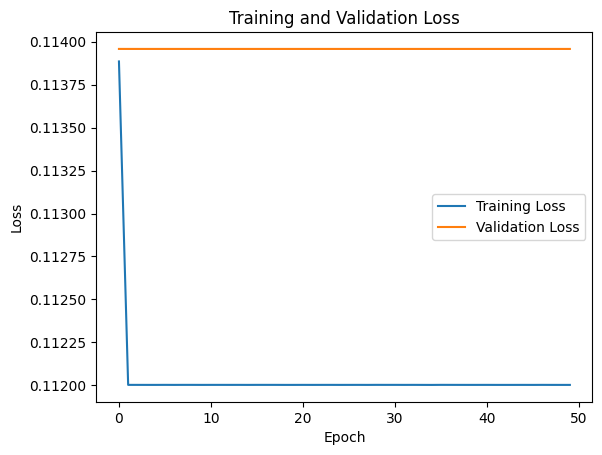

In [72]:
# Extract loss values from history
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']

# Plot training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Let's take a look at a summary of the encoder. Notice how the images are downsampled from 28x28 to 7x7.

In [73]:
autoencoder.encoder.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1320 (5.16 KB)
Trainable params: 1320 (5.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The decoder upsamples the images back from 7x7 to 28x28.

In [74]:
autoencoder.decoder.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_16 (Conv2  (None, 14, 14, 8)         584       
 DTranspose)                                                     
                                                                 
 conv2d_transpose_17 (Conv2  (None, 28, 28, 16)        1168      
 DTranspose)                                                     
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 1)         145       
                                                                 
Total params: 1897 (7.41 KB)
Trainable params: 1897 (7.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Plotting both the noisy images and the denoised images produced by the autoencoder.

In [75]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

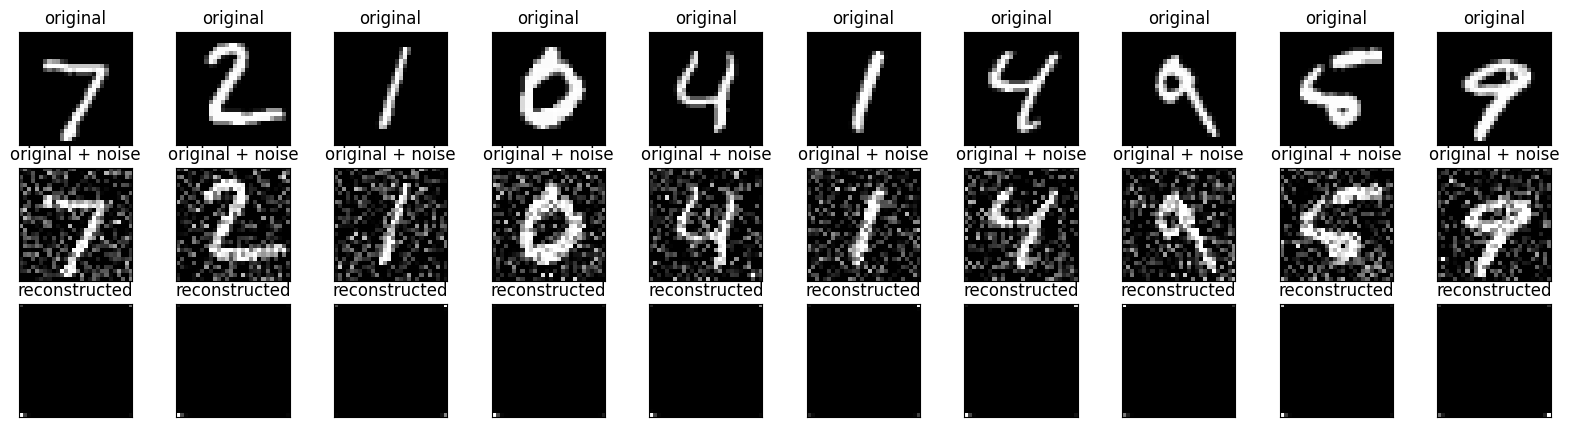

In [76]:
n = 10
plt.figure(figsize=(20, 5))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display original + noise
    ax = plt.subplot(3, n, i + n + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

plt.show()

### Define a vapad model

In this example, you will train a convolutional autoencoder using  [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers in the `encoder`, and [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers in the `decoder`.

In [77]:
! pip install tensorflow_addons

In [78]:
from vapad import *

In [79]:
vapad = VapadModel(input_shape=(28, 28, 1))
autoencoder = vapad.build_vapad_model()

In [80]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [81]:
%%time

with tf.device('/device:GPU:0'):
    history3 = autoencoder.fit(x_train_noisy, x_train,
                epochs=50,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/50
1875/1875 [==============================] - 105s 42ms/step - loss: 0.0686 - val_loss: 0.0681
Epoch 2/50
1875/1875 [==============================] - 77s 41ms/step - loss: 0.0676 - val_loss: 0.0677
Epoch 3/50
1875/1875 [==============================] - 76s 41ms/step - loss: 0.0675 - val_loss: 0.0677
Epoch 4/50
1875/1875 [==============================] - 75s 40ms/step - loss: 0.0675 - val_loss: 0.0676
Epoch 5/50
1875/1875 [==============================] - 75s 40ms/step - loss: 0.0674 - val_loss: 0.0677
Epoch 6/50
1875/1875 [==============================] - 75s 40ms/step - loss: 0.0674 - val_loss: 0.0677
Epoch 7/50
1875/1875 [==============================] - 77s 41ms/step - loss: 0.0674 - val_loss: 0.0675
Epoch 8/50
1875/1875 [==============================] - 76s 40ms/step - loss: 0.0674 - val_loss: 0.0684
Epoch 9/50
1875/1875 [==============================] - 75s 40ms/step - loss: 0.0674 - val_loss: 0.0681
Epoch 10/50
1875/1875 [==============================] - 75s 40

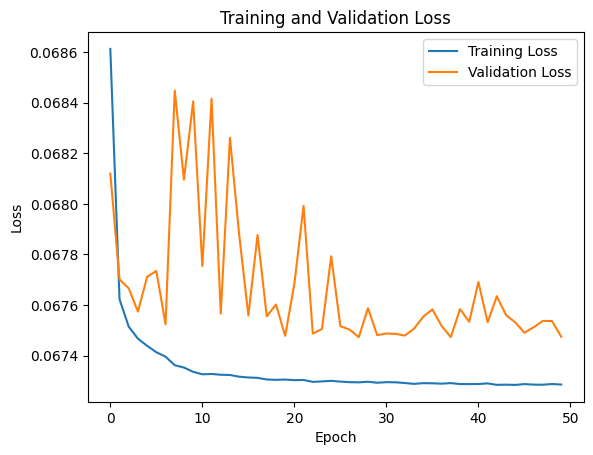

In [82]:
# Extract loss values from history
train_loss = history3.history['loss']
val_loss = history3.history['val_loss']

# Plot training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Plot the model.

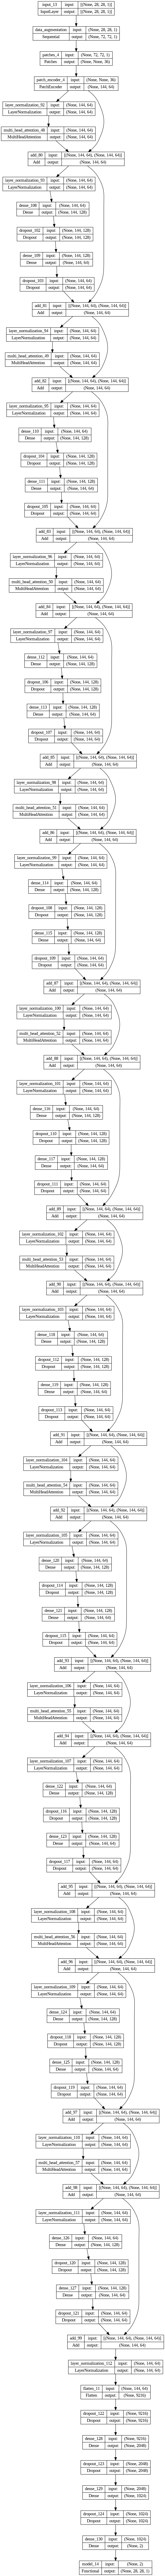

In [83]:
tf.keras.utils.plot_model(autoencoder, show_shapes=True)

Plotting both the noisy images and the denoised images produced by the autoencoder.

1/1 [==============================] - 0s 32ms/step


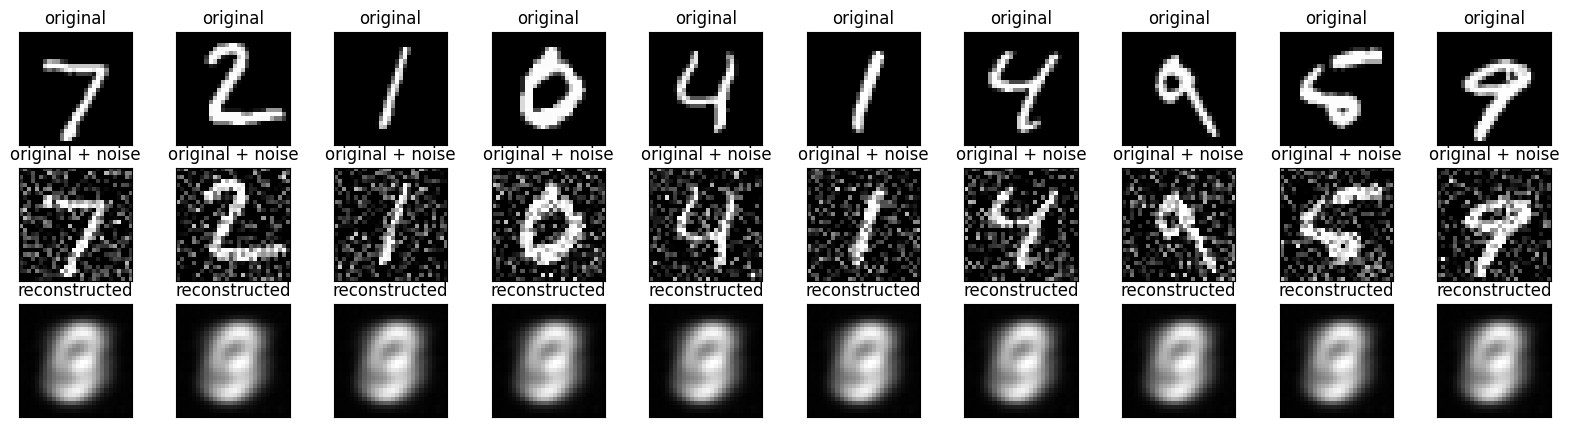

In [84]:
n = 10
plt.figure(figsize=(20, 5))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display original + noise
    ax = plt.subplot(3, n, i + n + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("reconstructed")
    reconstructed_img = autoencoder.predict(tf.expand_dims(x_test_noisy[i], axis=0)).reshape(28, 28)
    plt.imshow(tf.squeeze(reconstructed_img))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

plt.show()

## Third example: Image recovering


![Image denoising results](images/image_denoise_fmnist_results.png)

An autoencoder can also be trained to remove noise from images. In the following section, you will create a noisy version of the Fashion MNIST dataset by applying random noise to each image. You will then train an autoencoder using the noisy image as input, and the original image as the target.

Let's reimport the dataset to omit the modifications made earlier.

In [85]:
(x_train, _), (x_test, _) = mnist.load_data()

In [86]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


Adding random masks to the images

In [87]:
import numpy as np

# Define function to create masks with random blank spots
def create_random_masks(images, mask_size=(10, 10)):
    masked_images = []
    for image in images:
        # Copy the original image
        masked_image = np.copy(image)
        # Generate random positions for the blank spot
        x_pos = np.random.randint(0, image.shape[0] - mask_size[0])
        y_pos = np.random.randint(0, image.shape[1] - mask_size[1])
        # Apply the blank spot to the image
        masked_image[x_pos:x_pos+mask_size[0], y_pos:y_pos+mask_size[1]] = 0
        masked_images.append(masked_image)
    return np.array(masked_images)

In [88]:
# Apply the function to both training and testing data
x_train_masked = create_random_masks(x_train)
x_test_masked = create_random_masks(x_test)

Plot the noisy images.


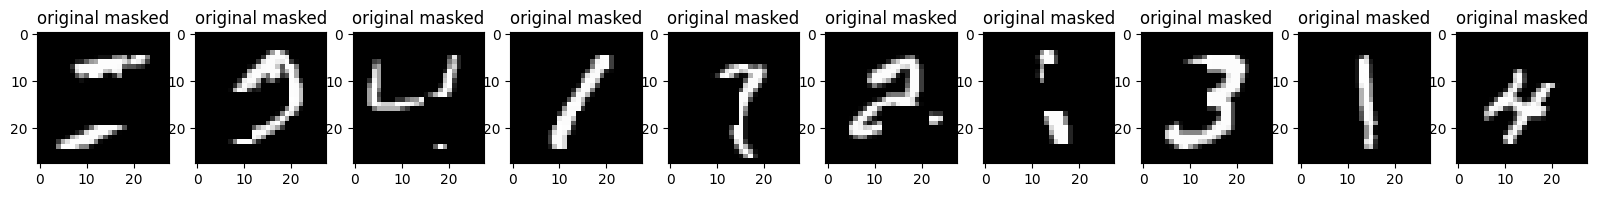

In [89]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original masked")
    plt.imshow(tf.squeeze(x_train_masked[i]))
    plt.gray()
plt.show()

In [90]:
vapad = VapadModel(input_shape=(28, 28, 1))
autoencoder = vapad.build_vapad_model()

In [91]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [92]:
%%time

with tf.device('/device:GPU:0'):
    history4 = autoencoder.fit(x_train_masked, x_train,
                epochs=50,
                shuffle=True,
                validation_data=(x_test_masked, x_test))

Epoch 1/50
1875/1875 [==============================] - 103s 41ms/step - loss: 0.0589 - val_loss: 0.0529
Epoch 2/50
1875/1875 [==============================] - 77s 41ms/step - loss: 0.0534 - val_loss: 0.0495
Epoch 3/50
1875/1875 [==============================] - 76s 41ms/step - loss: 0.0521 - val_loss: 0.0490
Epoch 4/50
1875/1875 [==============================] - 77s 41ms/step - loss: 0.0516 - val_loss: 0.0484
Epoch 5/50
1875/1875 [==============================] - 77s 41ms/step - loss: 0.0509 - val_loss: 0.0476
Epoch 6/50
1875/1875 [==============================] - 77s 41ms/step - loss: 0.0503 - val_loss: 0.0470
Epoch 7/50
1875/1875 [==============================] - 77s 41ms/step - loss: 0.0499 - val_loss: 0.0467
Epoch 8/50
1875/1875 [==============================] - 77s 41ms/step - loss: 0.0493 - val_loss: 0.0456
Epoch 9/50
1875/1875 [==============================] - 76s 41ms/step - loss: 0.0489 - val_loss: 0.0464
Epoch 10/50
1875/1875 [==============================] - 77s 41

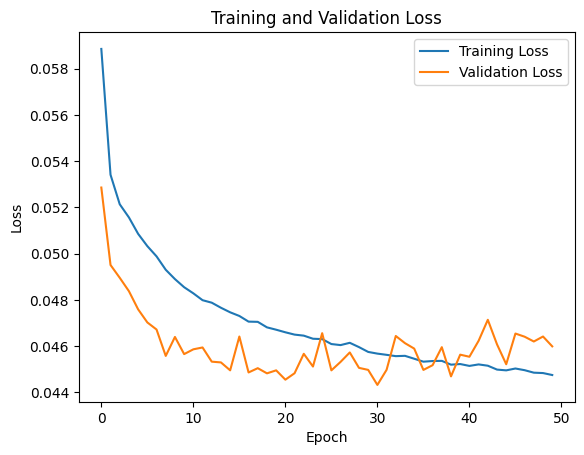

In [93]:
# Extract loss values from history
train_loss = history4.history['loss']
val_loss = history4.history['val_loss']

# Plot training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Plot the model.

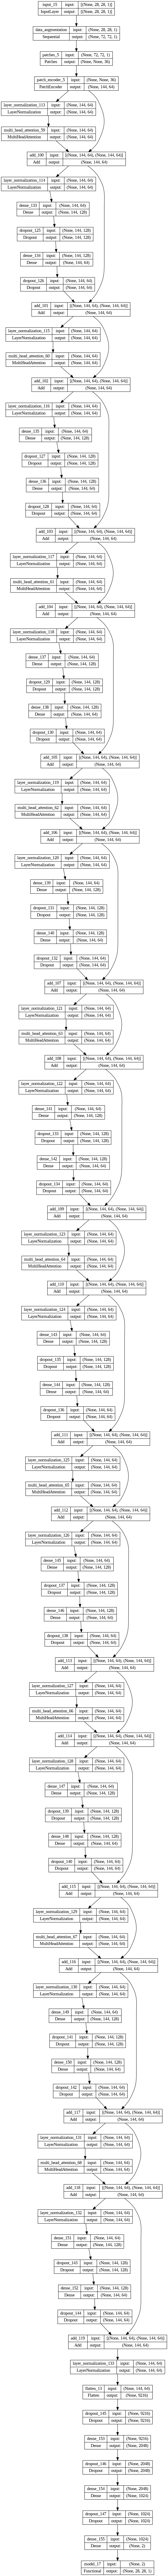

In [94]:
tf.keras.utils.plot_model(autoencoder, show_shapes=True)

Plotting both the noisy images and the denoised images produced by the autoencoder.

1/1 [==============================] - 0s 30ms/step


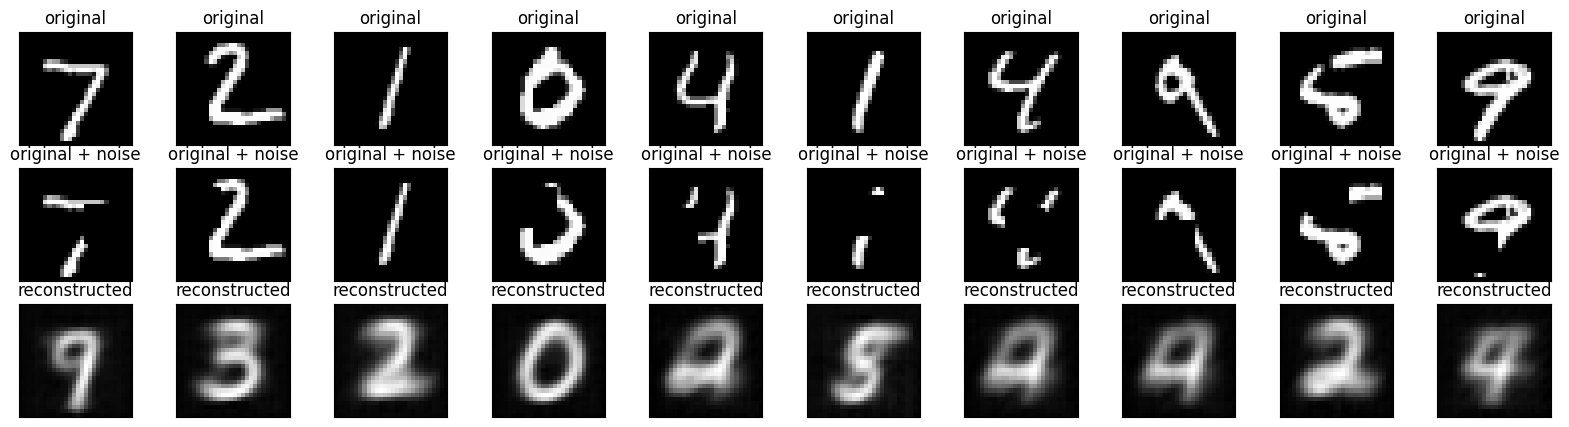

In [95]:
n = 10
plt.figure(figsize=(20, 5))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display original + noise
    ax = plt.subplot(3, n, i + n + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_masked[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("reconstructed")
    reconstructed_img = autoencoder.predict(tf.expand_dims(x_test_noisy[i], axis=0)).reshape(28, 28)
    plt.imshow(tf.squeeze(reconstructed_img))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

plt.show()